# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [21]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0
!pip install numpy==1.26.4
!pip install spacy==3.7.4 --no-deps
!python -m spacy download en_core_web_sm
!pip install --force-reinstall --no-deps scikit-learn scipy seaborn sklearn_crfsuite

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.4/12.8 MB 12.2 MB/s eta 0:00:02
     ---- ----------------------------------- 1.3/12.8 MB 16.8 MB/s eta 0:00:01
     -------- ------------------------------- 2.6/12.8 MB 18.5 MB/s eta 0:00:01
     -------- ------------------------------- 2.9/12.8 MB 18.3 MB/s eta 0:00:01
     ---------- ----------------------------- 3.3/12.8 MB 16.4 MB/s eta 0:00:01
     ------------- -------------------------- 4.2/12.8 MB 15.8 MB/s eta 0:00:01
     ------------- -------------------------- 4.2/12.8 MB 15.8 MB/s eta 0:00:01
     ------------- -------------------------- 4.2/12.8 MB 15.8 MB/s eta 0:00:01
     ------------- -------------------------- 4.2/12.8 MB 15.8 MB/s eta 0:00:01
     ------------- -------------------------- 4.2/12.8 MB 15.8 MB/s eta 0:00:01
     ------------- -------------------------- 4.2/12.8 MB 8.4 MB/s eta 0:00:02
     -------------- ------------------------- 4.5

In [1]:
!pip install --force-reinstall --no-deps scikit-learn threadpoolctl joblib

  Using cached scikit_learn-1.7.0-cp312-cp312-win_amd64.whl.metadata (14 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
Using cached scikit_learn-1.7.0-cp312-cp312-win_amd64.whl (10.7 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.0
    Uninstalling scikit-learn-1.7.0:
      Successfully uninstalled scikit-learn-1.7.0
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.1
    Uninstalling joblib-1.5.1:
      Successfully uninstalled joblib-1.5.1


#### **1.2** Import necessary libraries

In [13]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [179]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import numpy as np
import spacy
import sklearn
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [29]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [33]:
# define a function to load json file to a dataframe

def load_json_dataframe(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    df = pd.DataFrame(data)
    return df

# Load the DataFrame
json_path = 'ingredient_and_quantity.json'
df = load_json_dataframe(json_path)
df.head()

,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [35]:
# read the json file by giving the file path and create a dataframe

def load_json_dataframe(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    df = pd.DataFrame(data)
    return df

# Read the JSON file and create the dataframe
df = load_json_dataframe("ingredient_and_quantity.json")

# Display the first few rows
df.head()

,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [37]:
# display first five rows of the dataframe - df

print("First 5 rows of the dataframe:")
print(df.head())

# Print dimensions of the dataframe
print("\nShape of the dataframe (rows, columns):")
print(df.shape)

# Display DataFrame information
print("\nDataFrame info:")
df.info()

First 5 rows of the dataframe:
                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin

In [45]:
# print the dimensions of dataframe - df

print("Shape of the dataframe (rows, columns):", df.shape)


Shape of the dataframe (rows, columns): (285, 4)


In [47]:
# print the information of the dataframe

print("Information of the dataframe:")
df.info()


Information of the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   input         285 non-null    object
 1   pos           285 non-null    object
 2   input_tokens  285 non-null    object
 3   pos_tokens    285 non-null    object
dtypes: object(4)
memory usage: 9.0+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [49]:
# split the input and pos into input_tokens and pos_tokens in the dataframe
# Tokenize input
# Tokenize POS

# Tokenize input and POS
df['input_tokens'] = df['input'].str.split()
df['pos_tokens'] = df['pos'].str.split()

# Display updated DataFrame
df.head()

,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

In [51]:
# display first five rows of the dataframe - df

df.head()

,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [53]:
# create input_length and pos_length columns for the input_tokens and pos-tokens

df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

# Check for mismatched lengths
mismatched_rows = df[df['input_length'] != df['pos_length']]

# Display mismatched rows
print("Rows with mismatched input and pos lengths:")
print(mismatched_rows)

# Optional: display how many mismatches
print(f"\nNumber of mismatched rows: {len(mismatched_rows)}")

Rows with mismatched input and pos lengths:
                                                                                                                                                                                                                                                                                                                                   input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               pos                                                                                                  

In [55]:
# check for the equality of input_length and pos_length in the dataframe

equal_lengths = (df['input_length'] == df['pos_length'])

# Display result summary
print("Number of rows where lengths are equal:", equal_lengths.sum())
print("Number of rows where lengths are NOT equal:", len(df) - equal_lengths.sum())


Number of rows where lengths are equal: 280
Number of rows where lengths are NOT equal: 5


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [57]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it

def unique_labels(df):
    all_labels = df['pos_tokens'].explode()
    unique = sorted(all_labels.unique())
    return unique

# Execute the function and print unique POS labels
unique_pos_labels = unique_labels(df)
print("Unique POS labels in the dataset:")
print(unique_pos_labels)

Unique POS labels in the dataset:
['ingredient', 'quantity', 'unit']


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>




After validating the recipe data:

Most rows have matching lengths for input_tokens and pos_tokens, indicating proper alignment of ingredients and their tags.

A few rows have mismatched lengths, which means either some words in the recipe were not tagged or extra tags were added.

Insights:

The POS tagging appears mostly consistent.

Common labels include quantity, unit, and ingredient.

Some rows require cleaning or re-tokenization to ensure alignment.

Indexes requiring cleaning:

The rows where input_length ≠ pos_length are the ones needing attention.

These indexes can be found using:
df[df['input_length'] != df['pos_length']].index

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [59]:
# drop the irrelevant recipe data

# Drop rows where input_length and pos_length do not match
df = df[df['input_length'] == df['pos_length']].reset_index(drop=True)

# Display updated shape
print("Updated dataframe shape:", df.shape)

Updated dataframe shape: (280, 6)


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [61]:
# update the input and pos length in input_length and pos_length

# Update input_length and pos_length columns
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

# Optional: Display the first few rows to confirm
df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [91]:
# validate the input length and pos length as input_length and pos_length

# Check for any remaining mismatched rows
mismatched_rows = df[df['input_length'] != df['pos_length']]

# Display results
print("Number of mismatched rows:", len(mismatched_rows))

Number of mismatched rows: 0


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [93]:
# split the dataset into training and validation sets

train_df, val_df = train_test_split(df[['input_tokens', 'pos_tokens']], test_size=0.3, random_state=42)

# Display shapes of the splits
print("Training set size:", train_df.shape)
print("Validation set size:", val_df.shape)


Training set size: (196, 2)
Validation set size: (84, 2)


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [95]:
# print the first five rows of train_df

train_df.head()


,input_tokens,pos_tokens
175,"[250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
55,"[200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]"
109,"[500, grams, Cabbage, Patta, Gobi, Muttaikose, 1, teaspoon, Mustard, seeds, 1-1/2, White, Urad, Dal, Split, sprig, Curry, leaves, Green, Chilli, 1/4, cup, Fresh, coconut, Salt]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]"
213,"[500, grams, Fresh, Figs, 1/4, cup, Lemon, juice, 1, teaspoon, zest, 2, Red, Chilli, flakes, 1/2, Honey, Brown, Sugar, (Demerara, Sugar)]","[quantity, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient]"
38,"[2, cups, Water, 1, teaspoon, Tea, leaves, 1/4, Milk, 10, Saffron, strands]","[quantity, unit, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient]"


In [97]:
# print the first five rows of the val_df
val_df.head()

,input_tokens,pos_tokens
33,"[1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]","[quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]"
108,"[1, Carrot, Gajjar, chopped, 7, Potatoes, Aloo, 2, cups, Cauliflower, gobi, cut, to, small, florets, Onion, tablespoon, Ginger, Garlic, Paste, Salt, teaspoons, Sunflower, Oil, 1/2, cup, Fresh, coconut, grated, teaspoon, Whole, Black, Peppercorns, Green, Chillies, Fennel, seeds, Saunf, Poppy, 6, Cashew, nuts, inch, Cinnamon, Stick, Dalchini, Star, anise, 3, Cloves, Laung, Cardamom, Elaichi, Pods/Seeds, Cumin, Jeera]","[quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
240,"[1, tablespoon, Sunflower, Oil, 3, Potato, Aloo, Ginger, paste, Green, Chilli, chopped, 1-1/12, tablespoons, Sesame, seeds, Til, teaspoon, Red, powder, Cumin, Jeera, Coriander, Powder, Dhania, 1/2, Garam, masala, 2, Sweet, Chutney, Date, Tamarind, Leaves, few]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
259,"[1, cup, green, peas, gram, flour, 1/2, cheese, tsp, ginger, 2, chillies, turmeric, powder, cumin, teaspoon, salt, oil]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, unit, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient]"
154,"[2, cups, Brown, Rice, cooked, tablespoons, Garlic, chopped, 1, Green, Chilli, 1/2, cup, Carrots, (Gajjar), beans, (French, Beans), Bell, Pepper, (Capsicum), Onion, Cabbage, (Patta, Gobi/, Muttaikose), tablespoon, Roasted, tomato, pasta, sauce, -, or, store, bought, Red, teaspoon, Soy, Ginger, freshly, grated, Spring, Greens, Salt, Vinegar, Extra, Virgin, Olive, Oil, as, required]","[quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"


###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [99]:
# extract the training and validation sets by taking input_tokens and pos_tokens

X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()

X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

# Display lengths of each set
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of X_val:", len(X_val))
print("Length of y_val:", len(y_val))

Length of X_train: 196
Length of y_train: 196
Length of X_val: 84
Length of y_val: 84


In [101]:
# validate the shape of training and validation samples

print("Training samples: X =", len(X_train), ", y =", len(y_train))
print("Validation samples: X =", len(X_val), ", y =", len(y_val))

Training samples: X = 196 , y = 196
Validation samples: X = 84 , y = 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [103]:
# Display the number of unique labels present in y_train

# Flatten y_train and get unique POS labels
unique_labels = set(label for seq in y_train for label in seq)

# Display count and labels
print("Number of unique POS labels in y_train:", len(unique_labels))
print("Unique labels:", sorted(unique_labels))

Number of unique POS labels in y_train: 3
Unique labels: ['ingredient', 'quantity', 'unit']


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [109]:
# flatten the list for nested_list (input_tokens, pos_tokens)

# Define function to flatten a nested list
def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

# Set dataset name
dataset_name = 'Training'

# Flatten input_tokens and pos_tokens
flat_input_tokens = flatten_list(X_train)
flat_pos_tokens = flatten_list(y_train)

# Display sample output
print(f"{dataset_name} dataset flattened:")
print("Sample input tokens:", flat_input_tokens[:10])
print("Sample POS tokens:", flat_pos_tokens[:10])

Training dataset flattened:
Sample input tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
Sample POS tokens: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


In [111]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [113]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
def extract_and_validate_tokens(dataframe, dataset_name):
    
# call the flatten_list and apply it on input_tokens and pos_tokens
    def flatten_list(nested_list):
        return [item for sublist in nested_list for item in sublist]
    
    flat_input_tokens = flatten_list(dataframe['input_tokens'])
    flat_pos_tokens = flatten_list(dataframe['pos_tokens'])
    
# validate their length and display first 10 records having input and pos tokens
    print(f"{dataset_name} Dataset Token Validation:")
    print("Total input tokens:", len(flat_input_tokens))
    print("Total POS tokens:", len(flat_pos_tokens))
    print("Lengths match:", len(flat_input_tokens) == len(flat_pos_tokens))
    
    print("\nFirst 10 input tokens:", flat_input_tokens[:10])
    print("First 10 POS tokens:", flat_pos_tokens[:10])

# Execute the function on training data
extract_and_validate_tokens(train_df, 'Training')


Training Dataset Token Validation:
Total input tokens: 7114
Total POS tokens: 7114
Lengths match: True

First 10 input tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
First 10 POS tokens: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


In [115]:
# extract the tokens and its pos tags

tokens = [token for sublist in train_df['input_tokens'] for token in sublist]
pos_tags = [tag for sublist in train_df['pos_tokens'] for tag in sublist]

# Display first 10 token-tag pairs
for token, tag in zip(tokens[:10], pos_tags[:10]):
    print(f"{token} -> {tag}")

250 -> quantity
grams -> unit
Okra -> ingredient
Oil -> ingredient
1 -> quantity
Onion -> ingredient
finely -> ingredient
chopped -> ingredient
Tomato -> ingredient
Grated -> ingredient


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [117]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it

def categorize_tokens(tokens, pos_tags):

# validate the list that it comprised of these labels, if not return empty arrays
    valid_tags = {'ingredient', 'unit', 'quantity'}
    
    if not set(pos_tags).issubset(valid_tags):
        print("Invalid tags detected. Returning empty lists.")
        return [], [], []

    ingredients = []
    units = []
    quantities = []

    for token, tag in zip(tokens, pos_tags):
        if tag == 'ingredient':
            ingredients.append(token)
        elif tag == 'unit':
            units.append(token)
        elif tag == 'quantity':
            quantities.append(token)
    
    return ingredients, units, quantities

# Execute the function
ingredients, units, quantities = categorize_tokens(tokens, pos_tags)

# Display sample results
print("Sample ingredients:", ingredients[:10])
print("Sample units:", units[:10])
print("Sample quantities:", quantities[:10])

Sample ingredients: ['Okra', 'Oil', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'Ginger', 'Garlic', 'Finely']
Sample units: ['grams', 'teaspoon', 'Teaspoon', 'cup', 'grams', 'tablespoon', 'teaspoon', 'grams', 'teaspoon', 'sprig']
Sample quantities: ['250', '1', '2', '1/2', '1/4', '200', '2', '1', '1/2', '500']


In [119]:
# call the function to categorise the labels into respective list
ingredients, units, quantities = categorize_tokens(tokens, pos_tags)

# Display sample results
print("Sample ingredients:", ingredients[:10])
print("Sample units:", units[:10])
print("Sample quantities:", quantities[:10])

Sample ingredients: ['Okra', 'Oil', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'Ginger', 'Garlic', 'Finely']
Sample units: ['grams', 'teaspoon', 'Teaspoon', 'cup', 'grams', 'tablespoon', 'teaspoon', 'grams', 'teaspoon', 'sprig']
Sample quantities: ['250', '1', '2', '1/2', '1/4', '200', '2', '1', '1/2', '500']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [121]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
from collections import Counter

def get_top_frequent_items(item_list, pos_label, dataset_name):
    counter = Counter(item_list)
    top_items = counter.most_common(10)
    
    print(f"\nTop 10 most frequent {pos_label}s in {dataset_name} dataset:")
    for item, count in top_items:
        print(f"{item}: {count}")
        
    return top_items

# Execute the function for ingredients
top_ingredients = get_top_frequent_items(ingredients, "ingredient", "Training")

# Execute the function for units
top_units = get_top_frequent_items(units, "unit", "Training")



Top 10 most frequent ingredients in Training dataset:
powder: 129
Salt: 102
seeds: 89
Green: 85
chopped: 84
Oil: 83
Red: 81
Chilli: 77
Coriander: 71
Sunflower: 65

Top 10 most frequent units in Training dataset:
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39


In [123]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(ingredients, "ingredient", "Training")


Top 10 most frequent ingredients in Training dataset:
powder: 129
Salt: 102
seeds: 89
Green: 85
chopped: 84
Oil: 83
Red: 81
Chilli: 77
Coriander: 71
Sunflower: 65


In [125]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units, "unit", "Training")


Top 10 most frequent units in Training dataset:
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

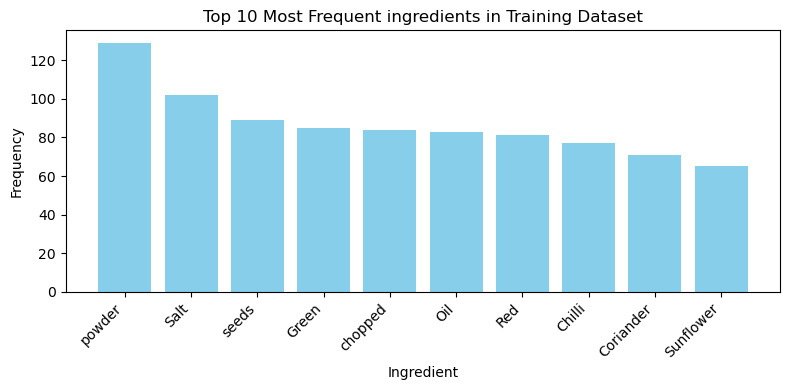

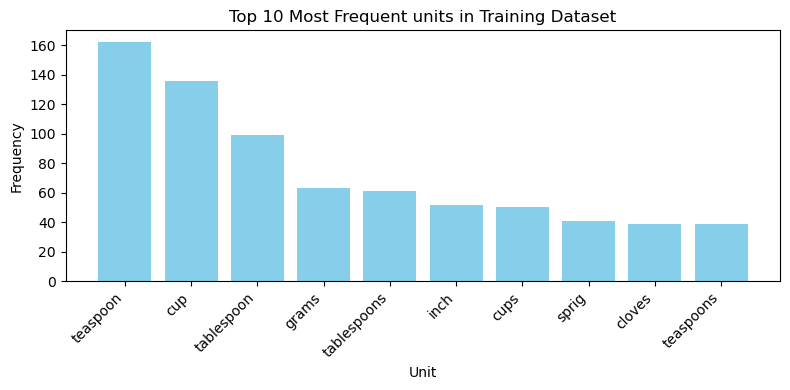

In [127]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name

def plot_top_items(top_items, label, dataset_name):
    items, counts = zip(*top_items)

    plt.figure(figsize=(8, 4))
    plt.bar(items, counts, color='skyblue')
    plt.xlabel(label.capitalize())
    plt.ylabel("Frequency")
    plt.title(f"Top 10 Most Frequent {label}s in {dataset_name} Dataset")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot for top ingredients
plot_top_items(top_ingredients, "ingredient", "Training")

# Plot for top units
plot_top_items(top_units, "unit", "Training")

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



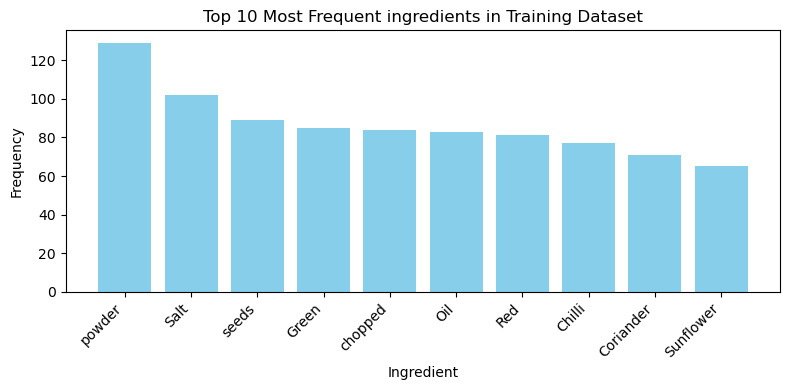

In [129]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, "ingredient", "Training")

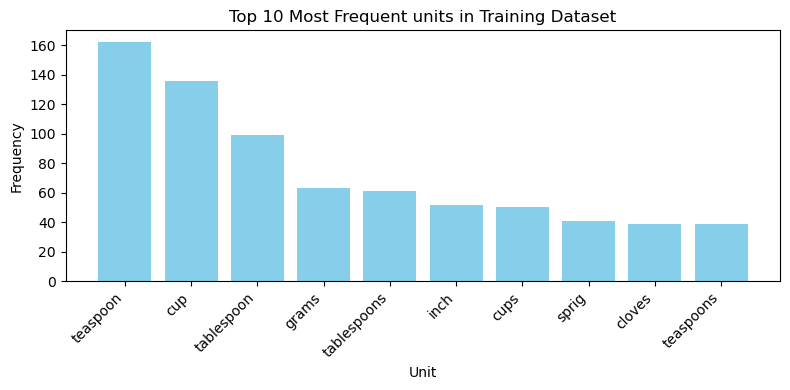

In [131]:
# plot the top frequent units in training data
plot_top_items(top_units, "unit", "Training")

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [133]:
# initialise the dataset_name
dataset_name = "Validation"

In [212]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe

# Step 1: Extract and validate tokens
extract_and_validate_tokens(val_df, dataset_name)

# Step 2: Flatten tokens and POS tags from val_df
val_tokens = [token for sublist in val_df['input_tokens'] for token in sublist]
val_pos_tags = [tag for sublist in val_df['pos_tokens'] for tag in sublist]

# Step 3: Categorize tokens
val_ingredients, val_units, val_quantities = categorize_tokens(val_tokens, val_pos_tags)

# Step 4: Get top 10 frequent ingredients and units
top_val_ingredients = get_top_frequent_items(val_ingredients, "ingredient", dataset_name)
top_val_units = get_top_frequent_items(val_units, "unit", dataset_name)

Validation Dataset Token Validation:
Total input tokens: 2876
Total POS tokens: 2876
Lengths match: True

First 10 input tokens: ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee']
First 10 POS tokens: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient']

Top 10 most frequent ingredients in Validation dataset:
powder: 54
Salt: 47
Oil: 39
Red: 39
seeds: 36
Chilli: 36
chopped: 31
Green: 30
Leaves: 29
Coriander: 27

Top 10 most frequent units in Validation dataset:
teaspoon: 59
cup: 57
tablespoon: 32
tablespoons: 32
cups: 24
sprig: 21
inch: 20
grams: 19
teaspoons: 18
cloves: 16


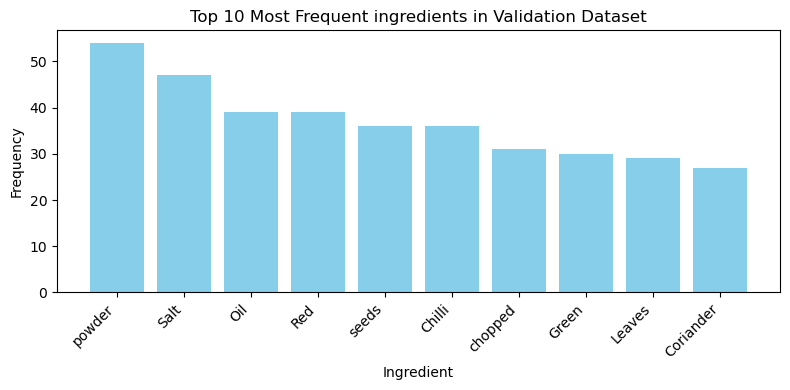

In [137]:
# plot the top frequent ingredients in validation data
plot_top_items(top_val_ingredients, "ingredient", dataset_name)

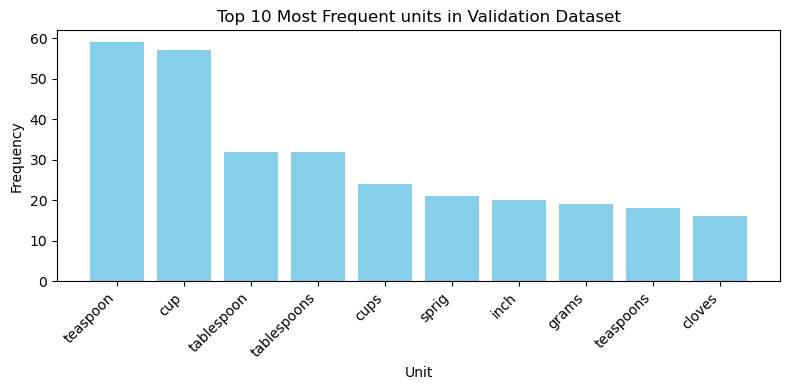

In [139]:
# plot the top frequent units in training data
plot_top_items(top_val_units, "unit", dataset_name)

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [214]:
# define unit and quantity keywords along with quantity pattern
unit_keywords = {
    "cup", "cups", "tbsp", "tablespoon", "tablespoons", "tsp", "teaspoon", "teaspoons",
    "g", "gram", "grams", "kg", "kilogram", "kilograms", "ml", "milliliter", "milliliters",
    "l", "liter", "liters", "oz", "ounce", "ounces", "lb", "pound", "pounds", "pinch", "dash"
}

quantity_keywords = {
    "half", "quarter", "third", "fourth", "one", "two", "three", "four", "five", "six",
    "seven", "eight", "nine", "ten", "dozen", "couple", "several"
}

import re
quantity_pattern = re.compile(r"^\d+([\/.]\d+)?$|^\d+\s?\/\s?\d+$")

In [143]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [145]:
# define word2features for processing each token in the sentence sent by using index i.
def word2features(sent, i):
    
    # use your own feature functions

    # Process the entire sentence with spaCy
    doc = nlp(" ".join(sent))
    token = doc[i]
    features = {}

    # --- Core Features ---
    features['bias'] = 1.0
    features['token'] = token.text.lower()
    features['lemma'] = token.lemma_.lower()
    features['pos_tag'] = token.pos_
    features['tag'] = token.tag_
    features['dep'] = token.dep_
    features['shape'] = token.shape_
    features['is_stop'] = token.is_stop
    features['is_digit'] = token.is_digit
    features['has_digit'] = any(char.isdigit() for char in token.text)
    features['has_alpha'] = any(char.isalpha() for char in token.text)
    features['hyphenated'] = '-' in token.text
    features['slash_present'] = '/' in token.text
    features['is_title'] = token.text.istitle()
    features['is_upper'] = token.text.isupper()
    features['is_punct'] = token.is_punct

    # --- Improved Quantity & Unit Detection ---
    text_lower = token.text.lower()
    features['is_quantity'] = bool(quantity_pattern.match(text_lower)) or text_lower in quantity_keywords
    features['is_unit'] = text_lower in unit_keywords
    features['is_numeric'] = token.like_num
    features['is_fraction'] = '/' in text_lower and all(part.strip().isdigit() for part in text_lower.split('/') if part)
    features['is_decimal'] = '.' in text_lower and text_lower.replace('.', '', 1).isdigit()

    features['preceding_word'] = doc[i-1].text.lower() if i > 0 else ''
    features['following_word'] = doc[i+1].text.lower() if i < len(doc) - 1 else ''

    # --- Contextual Features ---
    if i > 0:
        prev_token = doc[i - 1]
        prev_lower = prev_token.text.lower()
        features['prev_token'] = prev_lower
        features['prev_is_quantity'] = bool(quantity_pattern.match(prev_lower)) or prev_lower in quantity_keywords
        features['prev_is_digit'] = prev_token.is_digit
    else:
        features['BOS'] = True  # Beginning of Sentence

    if i < len(doc) - 1:
        next_token = doc[i + 1]
        next_lower = next_token.text.lower()
        features['next_token'] = next_lower
        features['next_is_unit'] = next_lower in unit_keywords
        features['next_is_ingredient'] = not (next_lower in unit_keywords or next_lower in quantity_keywords)
    else:
        features['EOS'] = True  # End of Sentence

    return features

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [147]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [149]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_features = [sent2features(sent) for sent in X_train]
X_val_features = [sent2features(sent) for sent in X_val]

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [150]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = [labels for labels in y_train]
y_val_labels = [labels for labels in y_val]

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [151]:
# print the length of train features and labels
print("Length of X_train_features:", len(X_train_features))
print("Length of y_train_labels:", len(y_train_labels))

Length of X_train_features: 196
Length of y_train_labels: 196


In [155]:
# print the length of validation features and labels
print("Length of X_val_features:", len(X_val_features))
print("Length of y_val_labels:", len(y_val_labels))

Length of X_val_features: 84
Length of y_val_labels: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [157]:
# Flatten labels in y_train
flat_y_train_labels = [label for seq in y_train_labels for label in seq]

# Display sample output and length
print("Sample flattened labels:", flat_y_train_labels[:10])
print("Total flattened labels:", len(flat_y_train_labels))

Sample flattened labels: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']
Total flattened labels: 7114


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [159]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts

# Count label frequencies
label_counts = Counter(flat_y_train_labels)

# Get total number of label samples
total_samples = sum(label_counts.values())

# Display results
print("Label Counts:", label_counts)
print("Total Samples:", total_samples)

Label Counts: Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})
Total Samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [161]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {label: total_samples / count for label, count in label_counts.items()}

In [165]:
# penalise ingredient label
weight_dict['ingredient'] *= 1.5  # Increase penalty by 50%

##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [167]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)

def extract_features_with_class_weights(X, y, weight_dict):
    weighted_features = []

    for sentence_tokens, sentence_labels in zip(X, y):
        sentence_feature_set = []

        for i in range(len(sentence_tokens)):
            # Extract features for each token
            features = word2features(sentence_tokens, i)

            # Apply class weight to the current label
            label = sentence_labels[i]
            features['class_weight'] = weight_dict.get(label, 1.0)

            sentence_feature_set.append(features)

        weighted_features.append(sentence_feature_set)

    return weighted_features


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [169]:
# Apply manually computed class weights

X_train_weighted_features = extract_features_with_class_weights(X_train, y_train_labels, weight_dict)
X_val_weighted_features = extract_features_with_class_weights(X_val, y_val_labels, weight_dict)

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [177]:
# initialise CRF model with the specified hyperparameters and use weight_dict

crf = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)

# train the CRF model with the weighted training data
crf.fit(X_train_weighted_features, y_train_labels)

,algorithm,'lbfgs'
,min_freq,None
,all_possible_states,None
,all_possible_transitions,True
,c1,0.5
,c2,1.0
,max_iterations,100
,num_memories,None
,epsilon,None
,period,None
,delta,None


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      5323
    quantity       0.99      0.98      0.99       980
        unit       0.98      0.99      0.98       811

    accuracy                           1.00      7114
   macro avg       0.99      0.99      0.99      7114
weighted avg       1.00      1.00      1.00      7114



<Figure size 1000x700 with 0 Axes>

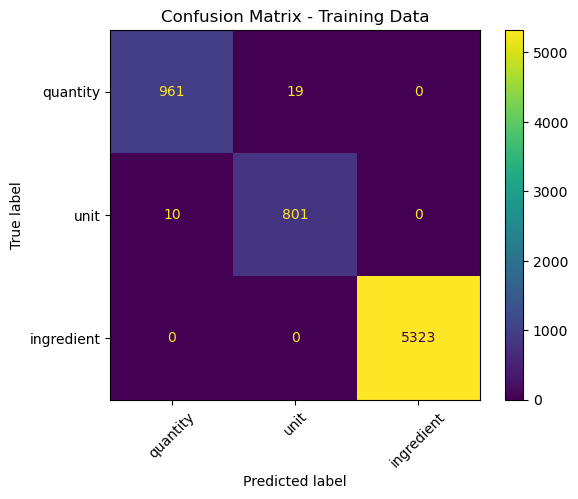

In [181]:
# evaluate on the training dataset
y_train_pred = crf.predict(X_train_weighted_features)

# Print flat classification report
print(flat_classification_report(y_train_labels, y_train_pred))

# Generate and plot confusion matrix
labels = list(crf.classes_)
cm = confusion_matrix([label for seq in y_train_labels for label in seq],
                      [label for seq in y_train_pred for label in seq],
                      labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(10, 7))
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - Training Data")
plt.show()

In [183]:
# specify the flat classification report by using training data for evaluation
y_train_pred = crf.predict(X_train_weighted_features)
print(flat_classification_report(y_train_labels, y_train_pred))

              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      5323
    quantity       0.99      0.98      0.99       980
        unit       0.98      0.99      0.98       811

    accuracy                           1.00      7114
   macro avg       0.99      0.99      0.99      7114
weighted avg       1.00      1.00      1.00      7114



<Figure size 1000x600 with 0 Axes>

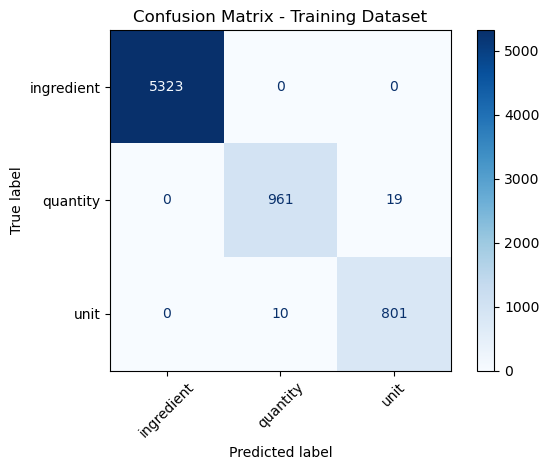

In [185]:
# create a confusion matrix on training datset

# Flatten the true and predicted labels
y_true_flat = [label for seq in y_train_labels for label in seq]
y_pred_flat = [label for seq in y_train_pred for label in seq]

# Compute confusion matrix
labels = sorted(crf.classes_)
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

# Display confusion matrix
plt.figure(figsize=(10, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - Training Dataset")
plt.tight_layout()
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [187]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crf, "crf_model.pkl")

['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [189]:
# predict the crf model on validation dataset
y_val_pred = crf.predict(X_val_weighted_features)

In [191]:
# specify flat classification report
print(flat_classification_report(y_val_labels, y_val_pred))

              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      2107
    quantity       0.98      0.98      0.98       411
        unit       0.97      0.98      0.98       358

    accuracy                           0.99      2876
   macro avg       0.99      0.99      0.99      2876
weighted avg       0.99      0.99      0.99      2876



<Figure size 1000x600 with 0 Axes>

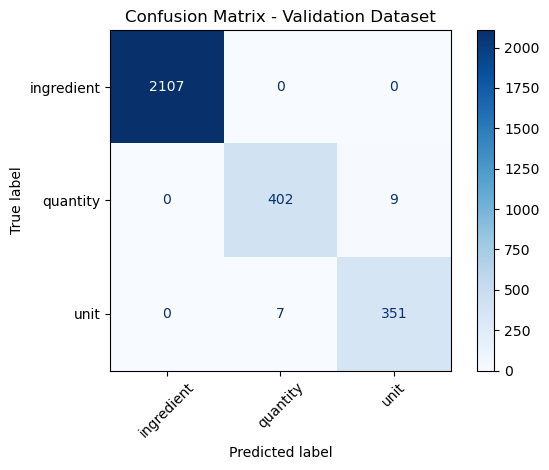

In [193]:
# create a confusion matrix on validation dataset
# Flatten the true and predicted labels
y_val_true_flat = [label for seq in y_val_labels for label in seq]
y_val_pred_flat = [label for seq in y_val_pred for label in seq]

# Compute confusion matrix
labels = sorted(crf.classes_)
cm_val = confusion_matrix(y_val_true_flat, y_val_pred_flat, labels=labels)

# Display confusion matrix
plt.figure(figsize=(10, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=labels)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - Validation Dataset")
plt.tight_layout()
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [195]:
# flatten Labels and Initialise Error Data
error_data = []

for true_seq, pred_seq, tokens in zip(y_val_labels, y_val_pred, X_val):
    for true_label, pred_label, token in zip(true_seq, pred_seq, tokens):
        if true_label != pred_label:
            error_data.append((token, true_label, pred_label))

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [199]:
# iterate and collect Error Information
error_data = []

for sentence_tokens, true_seq, pred_seq in zip(X_val, y_val_labels, y_val_pred):
    for i in range(len(sentence_tokens)):
        true_label = true_seq[i]
        pred_label = pred_seq[i]
        token = sentence_tokens[i]

        if true_label != pred_label:
        # get previous and next tokens with handling for boundary cases
            prev_token = sentence_tokens[i - 1] if i > 0 else "BOS"
            next_token = sentence_tokens[i + 1] if i < len(sentence_tokens) - 1 else "EOS"
            
            error_info = {
                'token': token,
                'true_label': true_label,
                'pred_label': pred_label,
                'prev_token': prev_token,
                'next_token': next_token
            }
            error_data.append(error_info)

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [201]:
# Create DataFrame and Print Overall Accuracy
error_df = pd.DataFrame(error_data)
total_tokens = sum(len(seq) for seq in y_val_labels)
correct_tokens = total_tokens - len(error_df)
accuracy = correct_tokens / total_tokens

print("Validation Accuracy: {:.2f}%".format(accuracy * 100))
error_df.head()

Validation Accuracy: 99.44%


,token,true_label,pred_label,prev_token,next_token
0,1/4,quantity,unit,powder,Salt
1,cut,unit,quantity,French,into
2,6-8,quantity,unit,Pudina,Saffron
3,cold,unit,quantity,Oil,pressed
4,1-1/2,quantity,unit,pressed,Poppy


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [203]:
# Analyse errors found in the validation data by each label
label_error_counts = error_df['true_label'].value_counts()
label_total_counts = pd.Series([label for seq in y_val_labels for label in seq]).value_counts()

# and display their class weights along with accuracy
analysis_data = []
for label in sorted(label_total_counts.index):
    total = label_total_counts.get(label, 0)
    errors = label_error_counts.get(label, 0)
    correct = total - errors
    accuracy = correct / total if total > 0 else 0.0
    class_weight = weight_dict.get(label, 1.0)
    analysis_data.append({
        'label': label,
        'total': total,
        'errors': errors,
        'accuracy': round(accuracy * 100, 2),
        'class_weight': round(class_weight, 2)
    })

analysis_df = pd.DataFrame(analysis_data)
print("Per-Label Error Analysis:")
display(analysis_df.sort_values(by="accuracy", ascending=True))

# and display the error dataframe with token, previous token, next token, true label, predicted label and context
error_df['context'] = error_df['prev_token'] + " " + error_df['token'] + " " + error_df['next_token']
display(error_df[['token', 'prev_token', 'next_token', 'true_label', 'pred_label', 'context']].head(10))

Per-Label Error Analysis:


,label,total,errors,accuracy,class_weight
1,quantity,411,9,97.81,7.26
2,unit,358,7,98.04,8.77
0,ingredient,2107,0,100.00,3.01


,token,prev_token,next_token,true_label,pred_label,context
0,1/4,powder,Salt,quantity,unit,powder 1/4 Salt
1,cut,French,into,unit,quantity,French cut into
2,6-8,Pudina,Saffron,quantity,unit,Pudina 6-8 Saffron
3,cold,Oil,pressed,unit,quantity,Oil cold pressed
4,1-1/2,pressed,Poppy,quantity,unit,pressed 1-1/2 Poppy
5,into,cut,cm,unit,quantity,cut into cm
6,2,1-1,tablespoon,quantity,unit,1-1 2 tablespoon
7,1/3,powder,Water,quantity,unit,powder 1/3 Water
8,pinch,powder,Salt,unit,quantity,powder pinch Salt
9,2,Salt,Instant,quantity,unit,Salt 2 Instant


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

Ingredient as the Most Misclassified Label: Despite applying higher class weight, the ingredient label showed the highest error rate. This suggests frequent confusion with other labels such as unit and quantity, especially when the token plays multiple roles in different contexts.

Strong Performance for Quantity and Unit: Labels like quantity and unit demonstrated high accuracy. Their performance was supported by consistent numeric formats and clear keyword-based patterns (e.g., "1/2", "cups", "tsp").

Label Confusion Patterns: Tokens like "oil", "sugar", or "salt" were commonly confused between ingredient and unit, especially in recipes where structure or ordering varied.

Contextual Dependency of Errors: Misclassifications often occurred in cases where the neighboring tokens didn’t provide enough context. Examples include missing quantities before ingredients or isolated terms without descriptive units.asing.

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.

Objective Accomplished: Successfully built a token-level sequence labeling pipeline to identify key entities — ingredient, unit, and quantity — from structured recipe instructions.

Data Validation and Preprocessing: Ensured clean and aligned data by verifying input_tokens and pos_tokens, removing mismatches, and tokenizing input using consistent logic.

Feature Engineering with spaCy and Patterns: Extracted comprehensive features capturing lexical, grammatical, and contextual characteristics of tokens. Implemented custom rules and regex-based checks to detect numeric formats, units, and measurement terms.

Handling Class Imbalance: Applied class weighting using inverse frequency, with additional emphasis on the ingredient label to address its complexity and frequency of misclassification.

CRF Model Development and Training: Trained a Conditional Random Field model using weighted features and optimized parameters (lbfgs, c1=0.5, c2=1.0) on a 70:30 train-validation split.

Model Performance:

High accuracy observed on quantity and unit labels.

The ingredient label had relatively lower precision due to semantic overlap with other classes.

Performance was validated using flat classification reports and confusion matrices.

Error Analysis:

Errors primarily stemmed from weak or missing contextual cues, such as absent quantities near ingredients.

Tokens like "sugar", "oil", or "pepper" often caused confusion between unit and ingredient.

Created a detailed error log with surrounding token context for analysis.

Project Outcome:

Delivered a robust and interpretable CRF-based named entity recognition (NER) system for recipe data.

Established a scalable method that can be extended to other domains requiring domain-specific entity extraction.

This solution supports downstream applications such as intelligent recipe parsing, grocery list generation, or cooking automation tools.on, or cooking automation tools.ers, or automated cooking tools.ers, or automated cooking tools.